In [1]:
from fedcore.algorithm.low_rank.low_rank_opt import LowRankModel
from fedcore.architecture.utils.misc import count_params
from fedcore.models.network_impl.decomposed_layers import IDecomposed
from fedcore.repository.constanst_repository import SLRStrategiesEnum
import torch.nn as nn
import torch
from fedcore.tools.metrics.two_model_compairing_metrics import compare_accuracy
from fedcore.tools.dataload.small_cifar10_dataloader import get_small_cifar10_train_and_val_loaders
from fedcore.tools.template_fedcore_models import create_low_rank_with_prune_on_0_epoch
import itertools
from copy import deepcopy
import pandas as pd
from fedcore.algorithm.low_rank.hooks import OnetimeRankPruner
from fedcore.tools.ruler import PerformanceEvaluator
softmax = nn.Softmax()

train_dataloader, val_dataloader = get_small_cifar10_train_and_val_loaders(batch_size=8, val_size=1000)

def experiment_body(trained_lr: LowRankModel, bs=8, thr=0.05, mode=SLRStrategiesEnum._member_names_[0], comp="one_layer", device_str="cpu", compare_with_decomposed=False, n_eval=8):
        """COMPAIRING INIT NON DECOMPOSED MODEL (model_before) WITH MODEL_AFTER
        WITH PRUNING
        """
        print(f"Running experiment bs={bs} thr={thr} mode={mode} compose={comp}")
        # copy model for experiment
        trained_lr = deepcopy(trained_lr)
        if (compare_with_decomposed):
            #if we want to compare decomposed & decomposed+compose+pruned
            trained_lr.model_before = deepcopy(trained_lr.model_after)

        #add correct compose_mode before composition by OneTimeRankPruner
        for name, module in trained_lr.model_after.named_modules():
            if isinstance(module, IDecomposed): 
                 module.compose_mode = comp

        #add pruner and execute
        rank_pruner = OnetimeRankPruner()
        rank_pruner.link_to_trainer(trained_lr.trainer)
        rank_pruner.non_adaptive_threshold = thr
        rank_pruner.SLR_strategy = mode
        rank_pruner.action(None, None)

        #creating performance evaluators
        val_loader_after = deepcopy(val_dataloader)
        device = torch.device(device_str)
        eval_before = PerformanceEvaluator(trained_lr.model_before, data=val_dataloader, batch_size=bs, device=device, n_batches=n_eval)
        eval_after = PerformanceEvaluator(trained_lr.model_after, data=val_loader_after, batch_size=bs, device=device, n_batches=n_eval)
        
        # run evaluation
        print("eval model_before")
        metrics_before = eval_before.eval()
        print("eval model_after")
        metrics_after = eval_after.eval()
        acc_before, acc_after = compare_accuracy(trained_lr.model_before, trained_lr.model_after, val_dataloader)

        # store row
        return {
            "batch_size": bs,
            "threshold": thr,
            "low_rank_mode": mode,
            "compose_mode": comp,
            "device": device_str,
            # before metrics
            "before_latency_mean s": metrics_before.get("latency", [None])[0] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
            "before_latency_std s": metrics_before.get("latency", [None, None])[1] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
            "before_throughput_mean s": metrics_before.get("throughput", [None])[0] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
            "before_throughput_std s": metrics_before.get("throughput", [None, None])[1] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
            "before_model_size_mb": metrics_before.get("model_size", [None])[0] if isinstance(metrics_before.get("model_size"), (list, tuple)) else None,
            "before_params": count_params(trained_lr.model_before),
            "before_accuracy": acc_before,
            # after metrics
            "after_params": count_params(trained_lr.model_after),
            "after_latency_mean s": metrics_after.get("latency", [None])[0] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
            "after_latency_std s": metrics_after.get("latency", [None, None])[1] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
            "after_throughput_mean s": metrics_after.get("throughput", [None])[0] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
            "after_throughput_std s": metrics_after.get("throughput", [None, None])[1] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
            "after_model_size_mb": metrics_after.get("model_size", [None])[0] if isinstance(metrics_after.get("model_size"), (list, tuple)) else None,
            "after_accuracy": acc_after,
        }

def full_experiment(trained_lr: LowRankModel, device_str, compare_with_decomposed=False, n_eval=8):
    batch_sizes = [8, 16] #16, 32]                     # можно расширить до 1..128
    thresholds = [0.0001, 0.1, 0.5, 0.9]#0.1, 0.2, 0.4]
    low_rank_modes = [SLRStrategiesEnum._member_names_[0]]
    compose_modes = ["one_layer", "two_layers", "three_layers"]


    rows = []
    all_iterations = len(batch_sizes) * len(thresholds) * len(low_rank_modes) * len(compose_modes)

    # loop over parameter grid
    i = 1
    for bs, thr, mode, comp in itertools.product(batch_sizes, thresholds, low_rank_modes, compose_modes):
        print("STEP:", i, "FROM", all_iterations)
        rows.append(experiment_body(trained_lr, bs, thr, mode, comp, device_str, compare_with_decomposed, n_eval))
        print(f"Done device={device_str} bs={bs} thr={thr} comp={comp}")
        i = i + 1
    return rows

TRAINED_LR, data = create_low_rank_with_prune_on_0_epoch(train_dataloader, val_dataloader, epochs=0) #TODO почему то уже даже при одной эпохе качество модели падает с 0.93 до 0.6
TRAINED_LR.fit(input_data=data)

/home/leostre/.local/share/virtualenvs/FedCore-wPuHcacz/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/leostre/.local/share/virtualenvs/FedCore-wPuHcacz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/leostre/.local/share/virtualenvs/FedCore-wPuHcacz/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


2025-11-19 13:18:00,556 - Device <cuda:0> is selected
2025-11-19 13:18:00,557 - Device <cuda:0> is selected
2025-11-19 13:18:00,557 - Device <cuda:0> is selected
LearningConfig(learning_strategy='from_checkpoint', peft_strategy='low_rank', criterion='cross_entropy', peft_strategy_params=LowRank(log_each=None, eval_each=None, save_each=None, epochs=0, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.5, finetune_params=NeuralModelConfig(log_each=None, eval_each=None, save_each=None, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}))), learning_strategy_params=N

ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [2]:
#after "fit" - model has all decomposed layers
assert TRAINED_LR.model_after.conv1.U is not None
assert TRAINED_LR.model_after.conv1.S is not None
assert TRAINED_LR.model_after.conv1.Vh is not None
#and it can forward
assert type(TRAINED_LR.model_after.conv1(next(iter(val_dataloader))[0])) == torch.Tensor

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [3]:
from datetime import datetime
layerwise_experiment_rows = full_experiment(TRAINED_LR, "cuda", n_eval=20)

df = pd.DataFrame(layerwise_experiment_rows)
ts = datetime.now().strftime("%d%m%Y_%H%M%S")
out_csv = f"low_rank_full_{ts}.csv"
df.to_csv(out_csv, index=False)
print(f"Saved results to {out_csv}")

# df = pd.read_csv("low_rank_full_18112025_151308.csv")

STEP: 1 FROM 24
Running experiment bs=8 thr=0.0001 mode=quantile compose=one_layer
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params
After rank pruning left only 100 % of layer3.1.conv1 l

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 637.95batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 666.10batch/s]


Done device=cuda bs=8 thr=0.0001 comp=one_layer
STEP: 2 FROM 24
Running experiment bs=8 thr=0.0001 mode=quantile compose=two_layers
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params
After

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 650.34batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 528.25batch/s]


Done device=cuda bs=8 thr=0.0001 comp=two_layers
STEP: 3 FROM 24
Running experiment bs=8 thr=0.0001 mode=quantile compose=three_layers
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params
Af

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 637.75batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 516.23batch/s]


Done device=cuda bs=8 thr=0.0001 comp=three_layers
STEP: 4 FROM 24
Running experiment bs=8 thr=0.1 mode=quantile compose=one_layer
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 654.42batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 643.18batch/s]


Done device=cuda bs=8 thr=0.1 comp=one_layer
STEP: 5 FROM 24
Running experiment bs=8 thr=0.1 mode=quantile compose=two_layers
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning left 

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 625.35batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 541.26batch/s]


Done device=cuda bs=8 thr=0.1 comp=two_layers
STEP: 6 FROM 24
Running experiment bs=8 thr=0.1 mode=quantile compose=three_layers
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 655.61batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 517.92batch/s]


Done device=cuda bs=8 thr=0.1 comp=three_layers
STEP: 7 FROM 24
Running experiment bs=8 thr=0.5 mode=quantile compose=one_layer
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning lef

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 641.69batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 649.18batch/s]


Done device=cuda bs=8 thr=0.5 comp=one_layer
STEP: 8 FROM 24
Running experiment bs=8 thr=0.5 mode=quantile compose=two_layers
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning left 

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 636.56batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 554.50batch/s]


Done device=cuda bs=8 thr=0.5 comp=two_layers
STEP: 9 FROM 24
Running experiment bs=8 thr=0.5 mode=quantile compose=three_layers
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 649.09batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 526.73batch/s]


Done device=cuda bs=8 thr=0.5 comp=three_layers
STEP: 10 FROM 24
Running experiment bs=8 thr=0.9 mode=quantile compose=one_layer
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 611.38batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 652.44batch/s]


Done device=cuda bs=8 thr=0.9 comp=one_layer
STEP: 11 FROM 24
Running experiment bs=8 thr=0.9 mode=quantile compose=two_layers
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning left

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 643.02batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 561.14batch/s]


Done device=cuda bs=8 thr=0.9 comp=two_layers
STEP: 12 FROM 24
Running experiment bs=8 thr=0.9 mode=quantile compose=three_layers
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning l

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 646.45batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 496.88batch/s]


Done device=cuda bs=8 thr=0.9 comp=three_layers
STEP: 13 FROM 24
Running experiment bs=16 thr=0.0001 mode=quantile compose=one_layer
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params
Afte

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 492.18batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 490.43batch/s]


Done device=cuda bs=16 thr=0.0001 comp=one_layer
STEP: 14 FROM 24
Running experiment bs=16 thr=0.0001 mode=quantile compose=two_layers
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params
Af

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 489.70batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 418.82batch/s]


Done device=cuda bs=16 thr=0.0001 comp=two_layers
STEP: 15 FROM 24
Running experiment bs=16 thr=0.0001 mode=quantile compose=three_layers
After rank pruning left only 100 % of conv1 layer params
After rank pruning left only 100 % of layer1.0.conv1 layer params
After rank pruning left only 100 % of layer1.0.conv2 layer params
After rank pruning left only 100 % of layer1.1.conv1 layer params
After rank pruning left only 100 % of layer1.1.conv2 layer params
After rank pruning left only 100 % of layer2.0.conv1 layer params
After rank pruning left only 100 % of layer2.0.conv2 layer params
After rank pruning left only 100 % of layer2.0.downsample.0 layer params
After rank pruning left only 100 % of layer2.1.conv1 layer params
After rank pruning left only 100 % of layer2.1.conv2 layer params
After rank pruning left only 100 % of layer3.0.conv1 layer params
After rank pruning left only 100 % of layer3.0.conv2 layer params
After rank pruning left only 100 % of layer3.0.downsample.0 layer params

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 486.36batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 403.25batch/s]


Done device=cuda bs=16 thr=0.0001 comp=three_layers
STEP: 16 FROM 24
Running experiment bs=16 thr=0.1 mode=quantile compose=one_layer
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruni

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 485.89batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 475.65batch/s]


Done device=cuda bs=16 thr=0.1 comp=one_layer
STEP: 17 FROM 24
Running experiment bs=16 thr=0.1 mode=quantile compose=two_layers
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 486.80batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 409.60batch/s]


Done device=cuda bs=16 thr=0.1 comp=two_layers
STEP: 18 FROM 24
Running experiment bs=16 thr=0.1 mode=quantile compose=three_layers
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 480.78batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 393.75batch/s]


Done device=cuda bs=16 thr=0.1 comp=three_layers
STEP: 19 FROM 24
Running experiment bs=16 thr=0.5 mode=quantile compose=one_layer
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 455.41batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 486.91batch/s]


Done device=cuda bs=16 thr=0.5 comp=one_layer
STEP: 20 FROM 24
Running experiment bs=16 thr=0.5 mode=quantile compose=two_layers
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 481.22batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 431.36batch/s]


Done device=cuda bs=16 thr=0.5 comp=two_layers
STEP: 21 FROM 24
Running experiment bs=16 thr=0.5 mode=quantile compose=three_layers
After rank pruning left only 50 % of conv1 layer params
After rank pruning left only 50 % of layer1.0.conv1 layer params
After rank pruning left only 50 % of layer1.0.conv2 layer params
After rank pruning left only 50 % of layer1.1.conv1 layer params
After rank pruning left only 50 % of layer1.1.conv2 layer params
After rank pruning left only 50 % of layer2.0.conv1 layer params
After rank pruning left only 50 % of layer2.0.conv2 layer params
After rank pruning left only 50 % of layer2.0.downsample.0 layer params
After rank pruning left only 50 % of layer2.1.conv1 layer params
After rank pruning left only 50 % of layer2.1.conv2 layer params
After rank pruning left only 50 % of layer3.0.conv1 layer params
After rank pruning left only 50 % of layer3.0.conv2 layer params
After rank pruning left only 50 % of layer3.0.downsample.0 layer params
After rank pruning

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 483.42batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 418.93batch/s]


Done device=cuda bs=16 thr=0.5 comp=three_layers
STEP: 22 FROM 24
Running experiment bs=16 thr=0.9 mode=quantile compose=one_layer
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 483.33batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 486.53batch/s]


Done device=cuda bs=16 thr=0.9 comp=one_layer
STEP: 23 FROM 24
Running experiment bs=16 thr=0.9 mode=quantile compose=two_layers
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning le

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 485.57batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 435.15batch/s]


Done device=cuda bs=16 thr=0.9 comp=two_layers
STEP: 24 FROM 24
Running experiment bs=16 thr=0.9 mode=quantile compose=three_layers
After rank pruning left only 12 % of conv1 layer params
After rank pruning left only 12 % of layer1.0.conv1 layer params
After rank pruning left only 12 % of layer1.0.conv2 layer params
After rank pruning left only 12 % of layer1.1.conv1 layer params
After rank pruning left only 12 % of layer1.1.conv2 layer params
After rank pruning left only 12 % of layer2.0.conv1 layer params
After rank pruning left only 12 % of layer2.0.conv2 layer params
After rank pruning left only 12 % of layer2.0.downsample.0 layer params
After rank pruning left only 12 % of layer2.1.conv1 layer params
After rank pruning left only 12 % of layer2.1.conv2 layer params
After rank pruning left only 11 % of layer3.0.conv1 layer params
After rank pruning left only 11 % of layer3.0.conv2 layer params
After rank pruning left only 12 % of layer3.0.downsample.0 layer params
After rank pruning

throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 471.01batch/s]


eval model_after


throughput eval batches: 100%|██████████| 20/20 [00:00<00:00, 423.06batch/s]


Done device=cuda bs=16 thr=0.9 comp=three_layers
Saved results to low_rank_full_19112025_131814.csv


In [4]:
df

,batch_size,threshold,low_rank_mode,compose_mode,device,before_latency_mean s,before_latency_std s,before_throughput_mean s,before_throughput_std s,before_model_size_mb,before_params,before_accuracy,after_params,after_latency_mean s,after_latency_std s,after_throughput_mean s,after_throughput_std s,after_model_size_mb,after_accuracy
0,8,0.0001,quantile,one_layer,cuda,1.045526,1.146810,0.116245,0.006544,42.655,11181642,0.9375,11181642,0.773245,0.065369,0.112398,0.003436,42.655,0.9375
1,8,0.0001,quantile,two_layers,cuda,0.773784,0.034827,0.115057,0.005725,42.655,11181642,0.9375,12664494,1.437298,1.700672,0.158999,0.005956,48.311,0.9375
2,8,0.0001,quantile,three_layers,cuda,0.788114,0.020639,0.116047,0.008020,42.655,11181642,0.9375,12668856,1.155750,0.037380,0.166442,0.006516,48.328,0.9375
3,8,0.1000,quantile,one_layer,cuda,0.789682,0.032484,0.115089,0.003654,42.655,11181642,0.9375,11181642,0.797654,0.031951,0.116953,0.006060,42.655,0.9375
4,8,0.1000,quantile,two_layers,cuda,0.810067,0.039898,0.119067,0.006203,42.655,11181642,0.9375,11411810,1.278072,0.964105,0.153793,0.004626,43.533,0.9375
5,8,0.1000,quantile,three_layers,cuda,0.854642,0.143291,0.114783,0.004388,42.655,11181642,0.9375,11415760,1.127662,0.023748,0.164246,0.006038,43.548,0.9375
6,8,0.5000,quantile,one_layer,cuda,0.813245,0.055106,0.117008,0.007149,42.655,11181642,0.9375,11181642,0.791374,0.028788,0.116275,0.005899,42.655,0.7625
7,8,0.5000,quantile,two_layers,cuda,0.804227,0.052594,0.116568,0.006819,42.655,11181642,0.9375,6338618,1.249314,0.975146,0.148684,0.004563,24.180,0.7625
8,8,0.5000,quantile,three_layers,cuda,0.813488,0.061201,0.114806,0.003216,42.655,11181642,0.9375,6340802,1.148664,0.090369,0.158699,0.004480,24.188,0.7625
9,8,0.9000,quantile,one_layer,cuda,0.819413,0.069139,0.121336,0.011652,42.655,11181642,0.9375,11181642,0.804760,0.057503,0.113399,0.004265,42.655,0.1875


In [5]:
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_latency_paired_grouped_5(df, target_characteristic_name="latency"):
    TARGET_CHARACTERISTIC_NAME = target_characteristic_name
    """
    Надёжная версия: для всех трёх фасетов берём mean/std прямо из колонок
    (before_latency_mean s / before_latency_std s / after_latency_mean s / after_latency_std s).
    Сравнения делаем по str-значениям меток, чтобы фасеты всегда заполнялись.
    Ожидает колонки: 'threshold','batch_size','compose_mode',
                     'before_latency_mean s','before_latency_std s',
                     'after_latency_mean s','after_latency_std s'
    """
    df2 = df.copy()
    df2["threshold"] = pd.to_numeric(df2["threshold"], errors="coerce")
    # df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    #     "threshold", "batch_size", "compose_mode",
    #     "before_latency_mean s", "after_latency_mean s",
    #     "before_throughput_mean s", "after_throughput_mean s"
    # ])
    if df2.empty:
        print("Нет валидных данных.")
        return

    def _paired_bars(ax, labels, before_mean, before_std, after_mean, after_std,
                     xlabel=None, ylabel="latency (s)"):
        x = np.arange(len(labels))
        width = 0.35
        before_mean = np.nan_to_num(np.array(before_mean, dtype=float), nan=0.0)
        after_mean = np.nan_to_num(np.array(after_mean, dtype=float), nan=0.0)
        before_std = np.nan_to_num(np.array(before_std, dtype=float), nan=0.0)
        after_std = np.nan_to_num(np.array(after_std, dtype=float), nan=0.0)

        ax.bar(x - width/2, before_mean, width, label="before", color="C0", alpha=0.6)
        ax.bar(x + width/2, after_mean, width, label="after", color="C1", alpha=0.6)

        # точки среднего и усы ±std (берём std из колонок)
        ax.errorbar(x - width/2, before_mean, yerr=before_std, fmt='o', color='black', capsize=4, elinewidth=1.2)
        ax.errorbar(x + width/2, after_mean, yerr=after_std, fmt='o', color='black', capsize=4, elinewidth=1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        if xlabel:
            ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()

    # helper: берём первую подходящую строку в subset для каждой метки (сравнение по str)
    def _collect_from_subset(subset, group_col, labels):
        before_mean = []
        before_std = []
        after_mean = []
        after_std = []
        if subset.empty:
            for _ in labels:
                before_mean.append(np.nan); before_std.append(np.nan)
                after_mean.append(np.nan); after_std.append(np.nan)
            return (before_mean, before_std, after_mean, after_std)

        col_as_str = subset[group_col].astype(str)
        for lbl in labels:
            mask = (col_as_str == str(lbl))
            if not mask.any():
                before_mean.append(np.nan); before_std.append(np.nan)
                after_mean.append(np.nan); after_std.append(np.nan)
            else:
                r = subset[mask].iloc[0]
                before_mean.append(r.get(f"before_{TARGET_CHARACTERISTIC_NAME}_mean s", np.nan))
                before_std.append(r.get(f"before_{TARGET_CHARACTERISTIC_NAME}_std s", np.nan))
                after_mean.append(r.get(f"after_{TARGET_CHARACTERISTIC_NAME}_mean s", np.nan))
                after_std.append(r.get(f"after_{TARGET_CHARACTERISTIC_NAME}_std s", np.nan))
        return (before_mean, before_std, after_mean, after_std)


    comp_vals = ["one_layer", "two_layers", "three_layers"]
    # 1) compose_mode dependence: facet by threshold (rows) and batch_size (cols)
    thr_vals = sorted(df2["threshold"].unique())
    bs_vals = sorted(df2["batch_size"].unique())
    nrows, ncols = max(1, len(thr_vals)), max(1, len(bs_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, bs in enumerate(bs_vals):
            ax = axes[i][j]
            subset = df2[(df2["threshold"] == thr) & (df2["batch_size"] == bs)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} bs={bs}")
                continue
            labels = comp_vals
            bm, bs_std, am, a_std = _collect_from_subset(subset, "compose_mode", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="compose_mode")
            ax.set_title(f"thr={thr}  bs={bs}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by compose_mode (faceted by threshold & batch_size)", y=1.02)
    plt.show()

    # 2) batch_size dependence: facet by threshold (rows) and compose_mode (cols), x=batch_size
    thr_vals = sorted(df2["threshold"].unique())
    nrows, ncols = max(1, len(thr_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            # фильтруем по threshold и compose_mode (строковые сравнения для compose_mode)
            subset = df2[(df2["threshold"] == thr) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} comp={comp}")
                continue
            # метки batch_size (строками), отсортировать по числовому значению
            labels = sorted(subset["batch_size"].astype(str).unique(), key=lambda x: float(x))
            bm, bs_std, am, a_std = _collect_from_subset(subset, "batch_size", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="batch_size")
            ax.set_title(f"thr={thr}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by batch_size (faceted by threshold & compose_mode)", y=1.02)
    plt.show()

    # 3) threshold dependence: facet by batch_size (rows) and compose_mode (cols), x=threshold
    bs_vals = sorted(df2["batch_size"].unique())
    thr_vals_sorted = sorted(df2["threshold"].unique())
    nrows, ncols = max(1, len(bs_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, bs in enumerate(bs_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            subset = df2[(df2["batch_size"] == bs) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"bs={bs} comp={comp}")
                continue
            # сохранить порядок порогов, но оставить только те, которые встречаются в subset
            available_thr = subset["threshold"].dropna().unique()
            labels = [str(x) for x in thr_vals_sorted if x in available_thr]
            if not labels:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                continue
            bm, bs_std, am, a_std = _collect_from_subset(subset, "threshold", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="threshold")
            ax.set_title(f"bs={bs}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by threshold (faceted by batch_size & compose_mode)", y=1.02)
    plt.show()

# ...existing code...

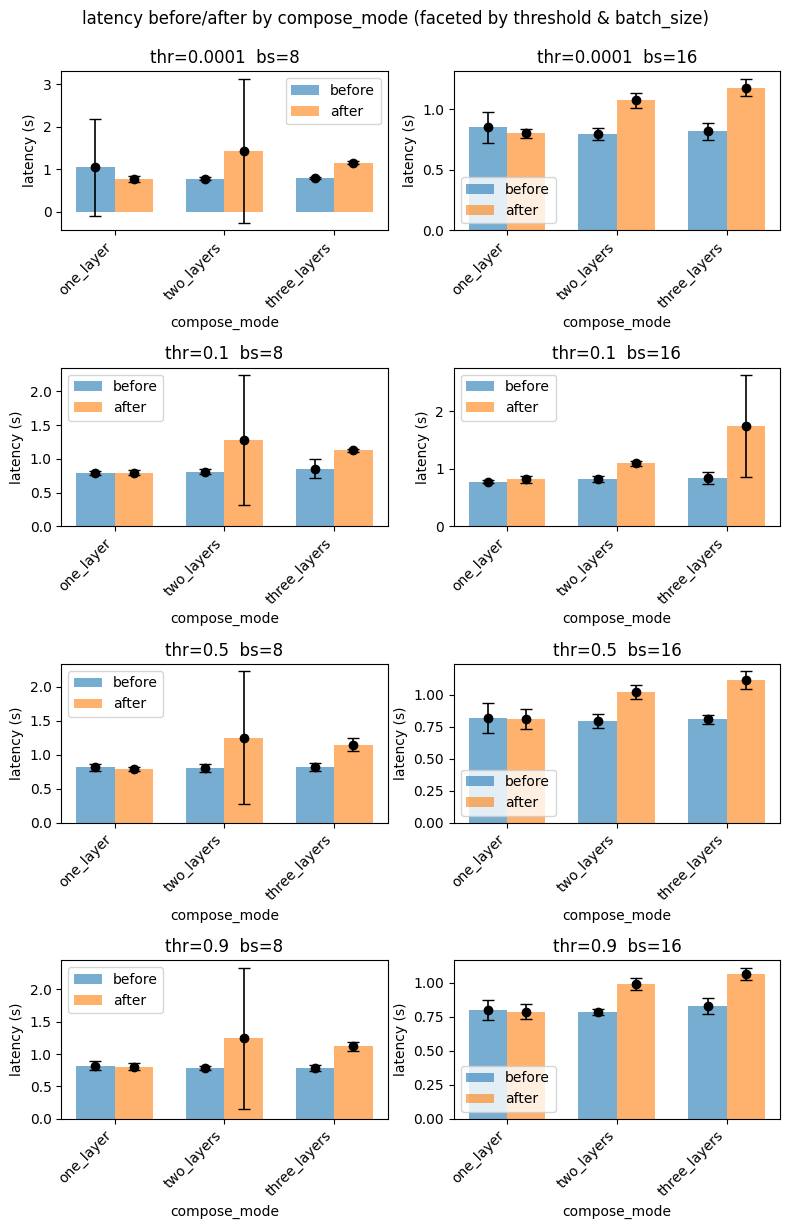

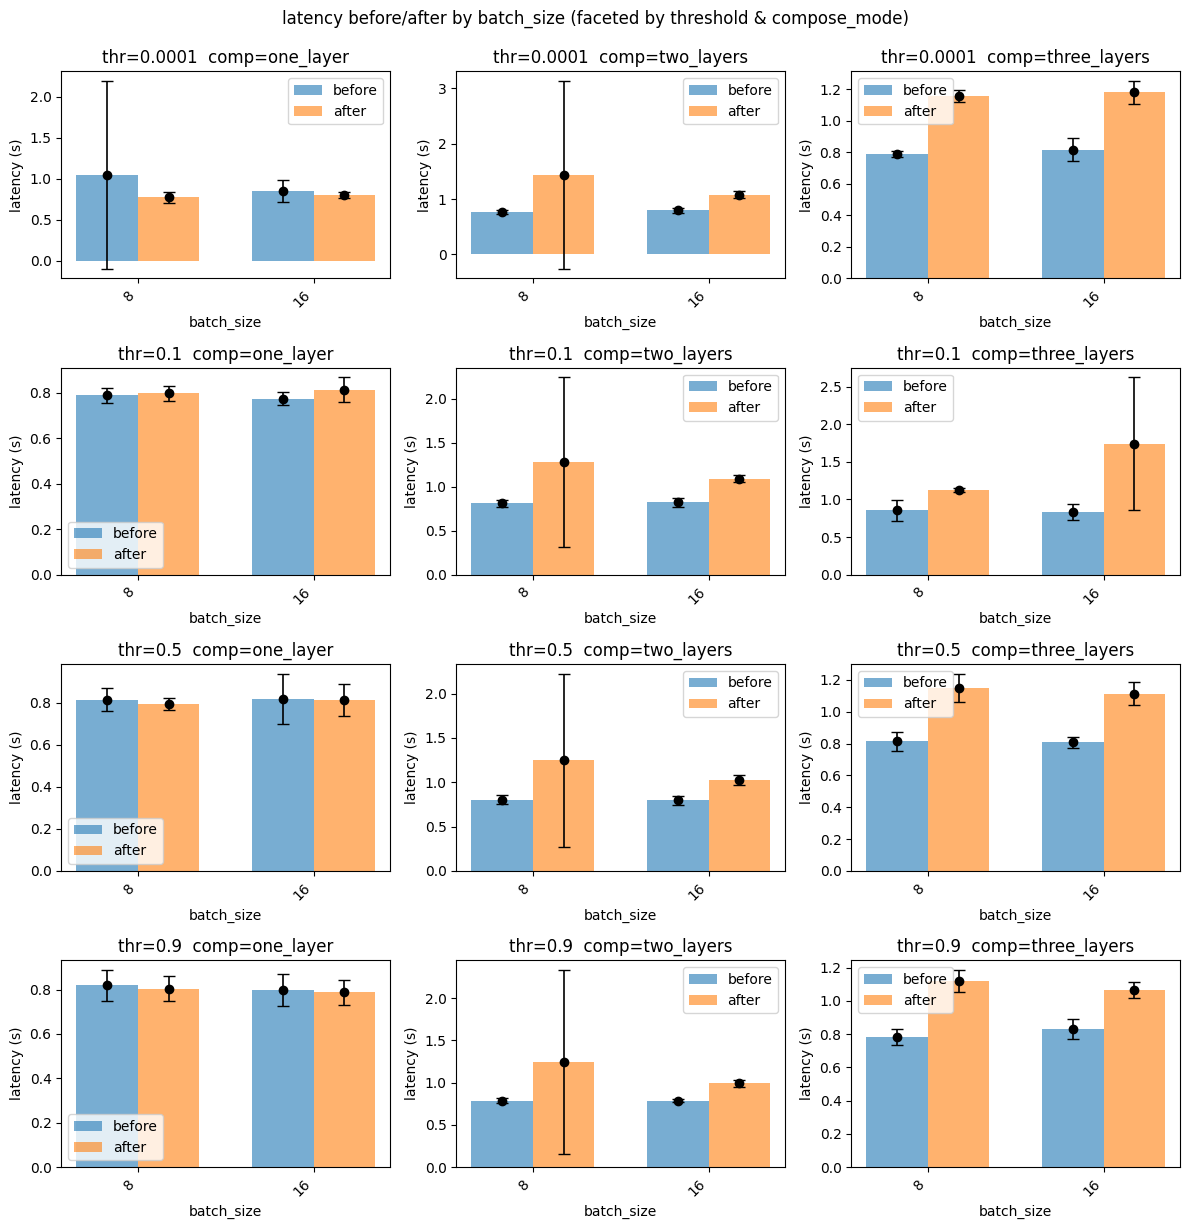

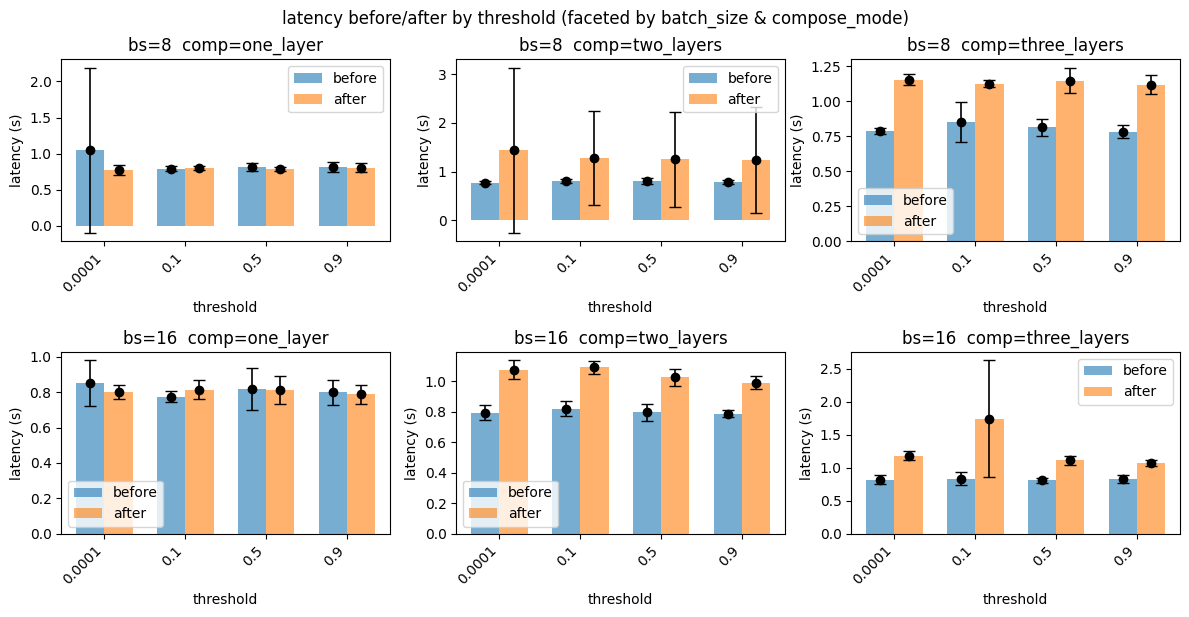

In [6]:
plot_latency_paired_grouped_5(df, target_characteristic_name="latency")

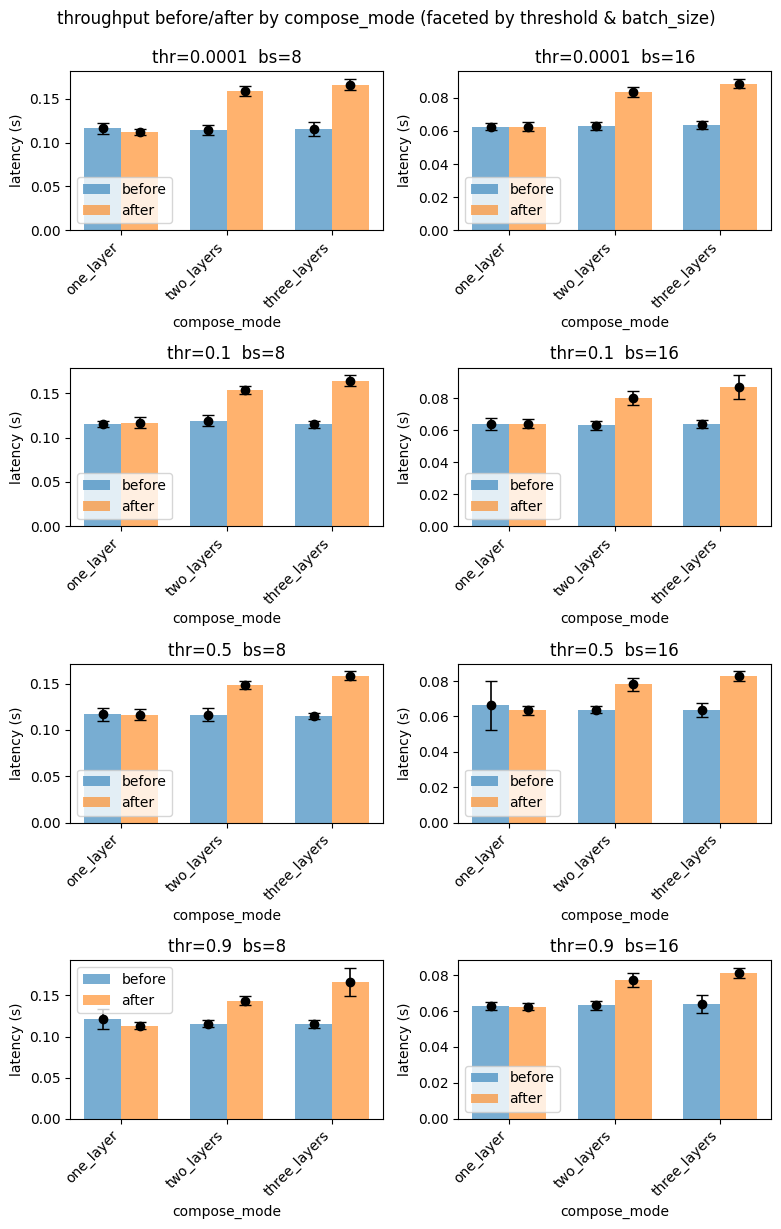

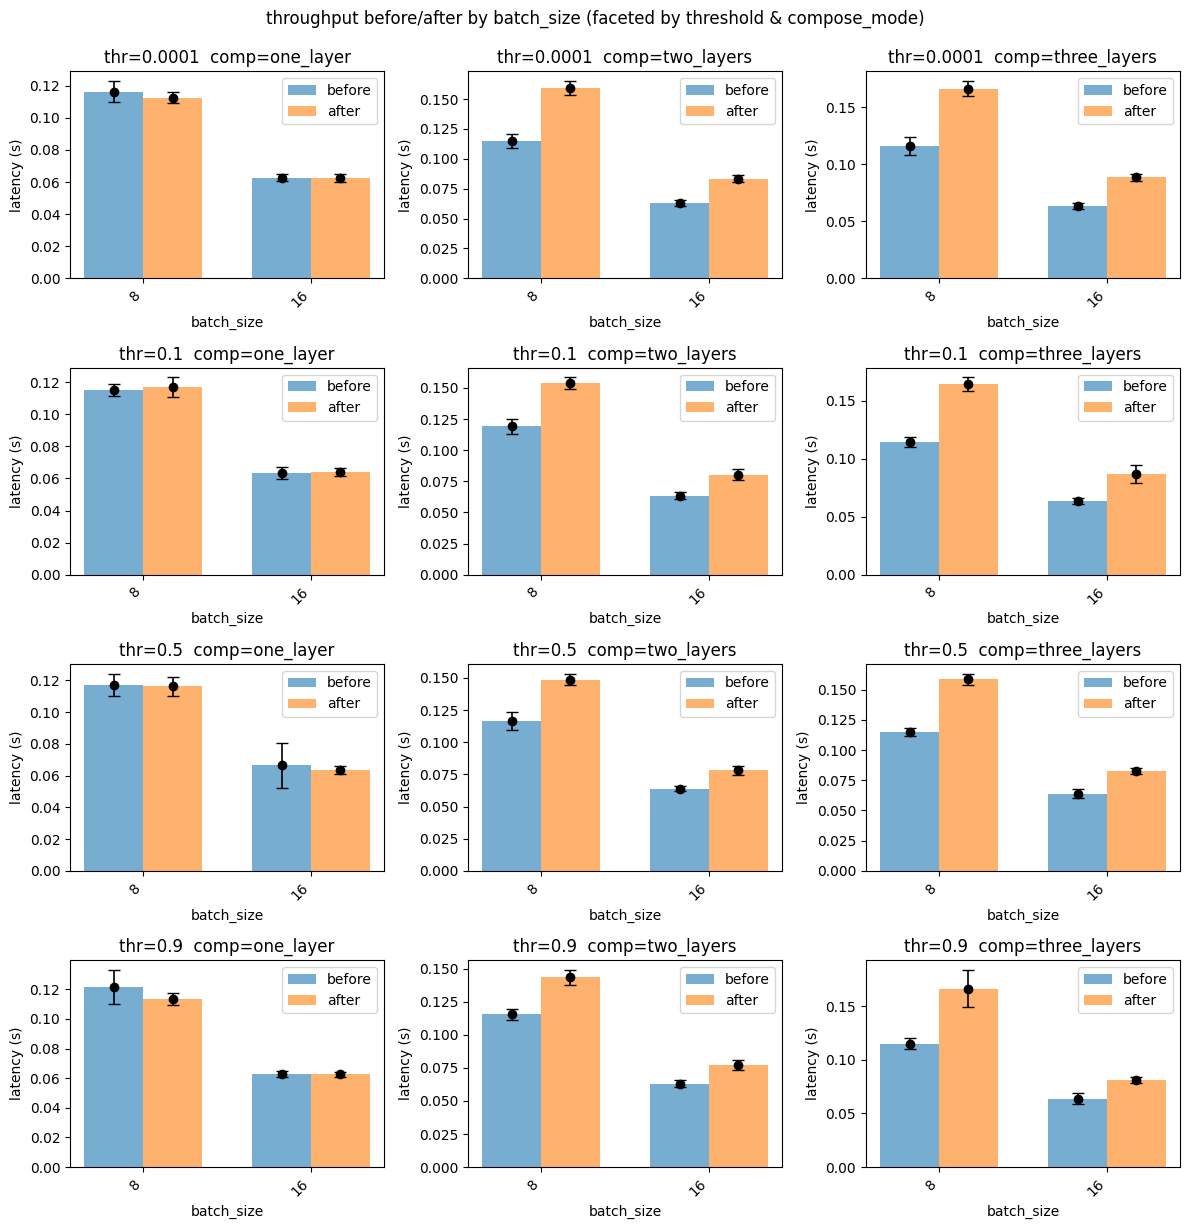

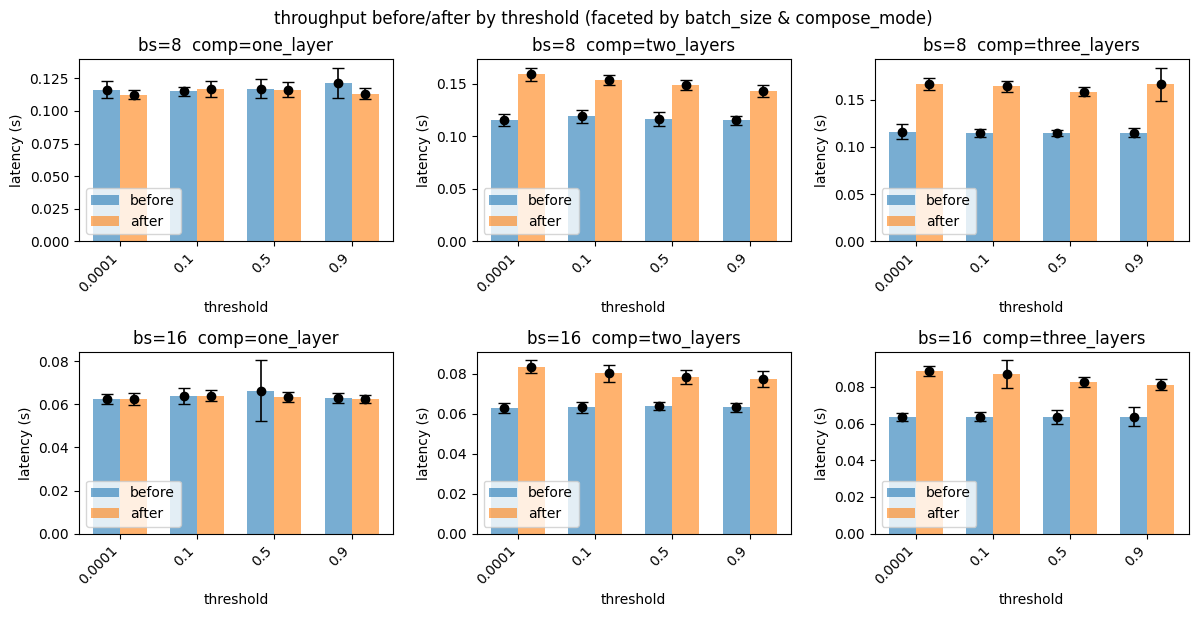

In [7]:
plot_latency_paired_grouped_5(df, target_characteristic_name="throughput")

In [8]:
# ...existing code...
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_accuracy_vs_threshold(df, use_mean=True):
    """
    Простой график зависимости after_accuracy от threshold.
    Если в таблице несколько записей на один threshold — усредняем (mean) и показываем std.
    Ожидает колонку 'after_accuracy' и 'threshold'.
    """
    df2 = df.copy()
    df2["threshold"] = pd.to_numeric(df2["threshold"], errors="coerce")

    stats = df2.groupby("threshold")["after_accuracy"].agg(["mean", "std", "count"]).reset_index()
    x = stats["threshold"].values
    y = stats["mean"].values
    yerr = stats["std"].fillna(0).values

    plt.figure(figsize=(6,4))
    if use_mean and len(stats) > 1:
        # линия со стандартным отклонением
        plt.errorbar(x, y, yerr=yerr, fmt="-o", capsize=4, label="mean ± std", color="C0")
    else:
        # просто точки (если нет повторов)
        plt.scatter(x, df2["after_accuracy"].values, color="C1", label="after_accuracy")

    plt.xlabel("threshold")
    plt.ylabel("after_accuracy")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.title("After accuracy vs threshold")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# пример вызова:
# plot_accuracy_vs_threshold(df)
# ...existing code...

Не забываем про падение accuracy и неприменимость больших обрезок

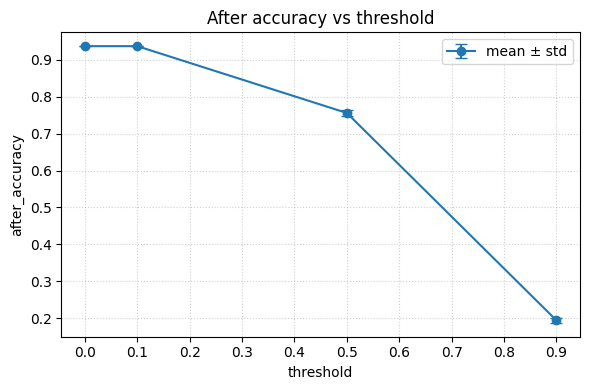

In [9]:
plot_accuracy_vs_threshold(df)

threshold > 0.4 вряд ли применим

In [10]:
# ...existing code...
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_params_vs_threshold(df, use_mean=True, compose_modes=None):
    """
    Для каждого compose_mode строим зависимость before_params / after_params от threshold
    (по одному графику на compose_mode). Поведение агрегации как раньше: если на один
    threshold несколько записей и use_mean=True — показываем mean ± std, иначе сырые точки.
    Ожидает колонки 'threshold', 'compose_mode' и одну или обе из ['before_params','after_params'].
    """

    df2 = df.copy()
    df2["threshold"] = pd.to_numeric(df2["threshold"], errors="coerce")
    df2["before_params"] = pd.to_numeric(df2.get("before_params"), errors="coerce")
    df2["after_params"] = pd.to_numeric(df2.get("after_params"), errors="coerce")
    df2 = df2.dropna(subset=["threshold"])

    comp_vals = ["one_layer", "two_layers", "three_layers"]


    n = len(comp_vals)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
    for i, comp in enumerate(comp_vals):
        ax = axes[0][i]
        subset = df2[df2.get("compose_mode", "").astype(str) == str(comp)] if "compose_mode" in df2.columns else df2.copy()
        if subset.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([]); ax.set_title(f"compose_mode={comp}")
            continue

        # агрегируем по threshold если нужно
        agg_map = {}
        if "before_params" in subset.columns:
            agg_map["before_params"] = ["mean", "std", "count"]
        if "after_params" in subset.columns:
            agg_map["after_params"] = ["mean", "std", "count"]


        stats = subset.groupby("threshold").agg(agg_map)
        stats.columns = ["_".join(col).strip() for col in stats.columns.values]
        stats = stats.reset_index().sort_values("threshold")
        x = stats["threshold"].values
        plotted = False
        if "before_params_mean" in stats.columns:
            ax.errorbar(x, stats["before_params_mean"].values,
                        yerr=stats["before_params_std"].fillna(0).values,
                        fmt="-o", capsize=4, label="before_params (mean ± std)", color="C2")
            plotted = True
        if "after_params_mean" in stats.columns:
            ax.errorbar(x, stats["after_params_mean"].values,
                        yerr=stats["after_params_std"].fillna(0).values,
                        fmt="-o", capsize=4, label="after_params (mean ± std)", color="C3")
            plotted = True
        if not plotted:
            ax.text(0.5, 0.5, "no numeric params", ha="center", va="center")

        ax.set_xlabel("threshold")
        ax.set_ylabel("params (count)")
        ax.set_xticks(np.arange(0, 1, 0.1))
        ax.set_title(f"compose_mode={comp}")
        #ax.set_xticks(np.unique(sorted(subset["threshold"].values)))
        ax.grid(True, linestyle=":", alpha=0.5)
        ax.legend()

    plt.tight_layout()
    plt.suptitle("Before/After params vs threshold (separate by compose_mode)", y=1.02)
    plt.show()

# ...existing code...

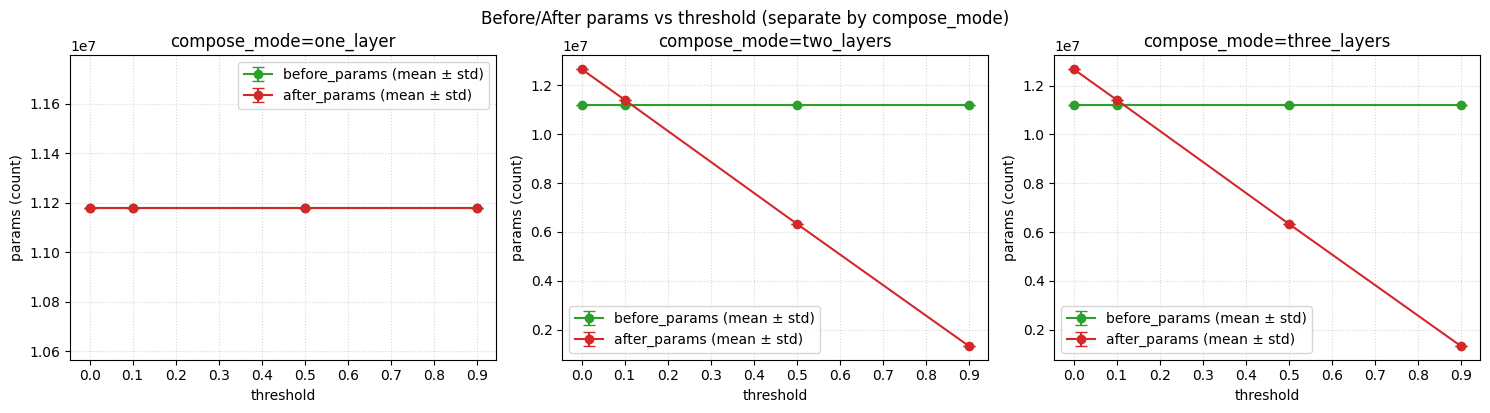

In [11]:
plot_params_vs_threshold(df)

In [12]:
df_some = df[df["threshold"] == 0.9]
df_some[["after_params", "compose_mode"]]

,after_params,compose_mode
9,11181642,one_layer
10,1335370,two_layers
11,1335850,three_layers
21,11181642,one_layer
22,1335370,two_layers
23,1335850,three_layers


Сжатие работает только на режимах 2 и 3 (очевидно). При этом сильно не отличается 2 от 3, так как последняя матричка S обычно маленькая и не влияет практически на сумму.

In [13]:
from scipy import stats
df_typical = df[(df["threshold"] == 0.1) & (df["compose_mode"] == "two_layers") & (df["batch_size"] == 16)]
df_typical["abs_througpohut_increase"] = (df_typical["after_throughput_mean s"] - df_typical["before_throughput_mean s"])
df_typical["relative_througpohut_increase"] = df_typical["abs_througpohut_increase"] / df_typical["before_throughput_mean s"]
df_typical["relative_througpohut_increase"]

16    0.268796
Name: relative_througpohut_increase, dtype: float64

Для всей модели замедление составило около 46% на "обычных" параметраx. (two_layers decomp)

In [14]:
from scipy import stats
df_typical_three = df[(df["threshold"] == 0.1) & (df["compose_mode"] == "three_layers") & (df["batch_size"] == 16)]
df_typical_three["abs_througpohut_increase"] = df_typical_three["after_throughput_mean s"] - df_typical_three["before_throughput_mean s"]
df_typical_three["relative_througpohut_increase"] = df_typical_three["abs_througpohut_increase"] / df_typical_three["before_throughput_mean s"]
df_typical_three["relative_througpohut_increase"]

17    0.36244
Name: relative_througpohut_increase, dtype: float64

31% для тройного разложения

In [15]:
df[["batch_size",	"threshold",	"compose_mode", "before_throughput_mean s", "after_throughput_mean s"]]

,batch_size,threshold,compose_mode,before_throughput_mean s,after_throughput_mean s
0,8,0.0001,one_layer,0.116245,0.112398
1,8,0.0001,two_layers,0.115057,0.158999
2,8,0.0001,three_layers,0.116047,0.166442
3,8,0.1000,one_layer,0.115089,0.116953
4,8,0.1000,two_layers,0.119067,0.153793
5,8,0.1000,three_layers,0.114783,0.164246
6,8,0.5000,one_layer,0.117008,0.116275
7,8,0.5000,two_layers,0.116568,0.148684
8,8,0.5000,three_layers,0.114806,0.158699
9,8,0.9000,one_layer,0.121336,0.113399
